In [65]:
import os
import pandas as pd
import numpy as np
import polars as pl
import re
import swifter
from tqdm.auto import tqdm

# Visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from plotly import graph_objs as go

# NLP
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from transformers import pipeline

# Dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

# Set the display options to show the full text
pd.set_option('display.max_colwidth', None)

In [66]:
#Create a function to clean the tweets
def clean_text(text):
    text = re.sub(r'@[A-Za-z0–9]+', '', text) #Remove @mentions replace with blank
    text = re.sub(r'#', '', text) #Remove the ‘#’ symbol, replace with blank
    text = re.sub(r'RT[\s]+', '', text) #Removing RT, replace with blank
    text = re.sub(r'https?:\/\/\S+', '', text) #Remove the hyperlinks
    text = re.sub(r':', '', text) # Remove :
    return text

def deEmojify(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [67]:
# Load the data
df = pl.read_csv('c:/Users/Stamatis/Desktop/MLCryptoPredictor/MLCryptoPredictor/data/external/Social_Media/csv/Bitcoin_tweets.csv', ignore_errors=True)
df_2 = pl.read_csv('c:/Users/Stamatis/Desktop/MLCryptoPredictor/MLCryptoPredictor/data/external/Social_Media/csv/Bitcoin_tweets_dataset_2.csv', ignore_errors=True)

df_tweet1 = df.to_pandas()
df_tweet2 = df_2.to_pandas()

In [68]:
# Concatenate the two dataframes
df_concat_tweet = pd.concat([df_tweet1, df_tweet2], ignore_index=True)

df_concat_tweet.shape

(4863792, 13)

In [69]:
df_concat_tweet['date'] = pd.to_datetime(df_concat_tweet['date'], errors='coerce')
df_concat_tweet['date'] = df_concat_tweet['date'].dt.strftime("%Y-%m-%d")
df_concat_tweet = df_concat_tweet.dropna(subset=['date'])

In [70]:
min_date = df_concat_tweet['date'].min()
max_date = df_concat_tweet['date'].max()

print("Lowest Date:", min_date)
print("Highest Date:", max_date)

Lowest Date: 2021-02-05
Highest Date: 2023-03-05


In [71]:
df_concat_tweet.dropna(axis=0 ,subset=['date','text'],inplace = True)
df_concat_tweet.reset_index(drop= True,inplace=True)

df_concat_tweet.drop_duplicates(inplace = True)
df_concat_tweet.reset_index(drop=True,inplace=True)

In [72]:
df_concat_tweet['text'] = df_concat_tweet['text'].swifter.progress_bar(True).apply(clean_text)
df_concat_tweet['text'] = df_concat_tweet['text'].swifter.progress_bar(True).apply(deEmojify)

Pandas Apply:   0%|          | 0/4858478 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4858478 [00:00<?, ?it/s]

In [73]:
## Features for the model

df_group = df_concat_tweet.copy()
df_group = df_group.groupby('date').agg({'user_name': 'nunique', 'user_followers': 'sum', 'text' : 'count'}).reset_index()
df_group.columns = ['date', 'unique_users', 'followers', 'tweet_count']

In [74]:
df_concat_tweet = df_concat_tweet[['date','text']]

In [75]:
df_concat_tweet.drop_duplicates(subset=['text'],inplace=True)

### FinBert

In [76]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
# model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
labels = ["positive", "negative", "neutral"]
# os.environ["TOKENIZERS_PARALLELISM"] = "false"

pipe = pipeline("text-classification", model= model, tokenizer= tokenizer)

def estimate_sentiment_single(news):
    if news:
        sentiment  = pipe(news)
        return sentiment[0]['label']
    else:
        return 'neutral'

In [77]:
df_concat_tweet['sentiment'] = df_concat_tweet['text'].swifter.progress_bar(True).apply(estimate_sentiment_single)

Pandas Apply:   0%|          | 0/4192903 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [55]:
# df_concat_tweet['sentiment'] = df_concat_tweet['text'].swifter.apply(estimate_sentiment_single)

KeyboardInterrupt: 

## PySpark

In [3]:
# from pyspark.sql import SparkSession
# from pyspark.sql.functions import udf
# from pyspark.sql.types import StringType

# # Initialize SparkSession
# spark = SparkSession.builder \
#     .appName("SentimentAnalysis") \
#     .getOrCreate()
    
# # Load the data
# # Load CSV files into Spark DataFrame
# df1 = spark.read.csv('c:/Users/Stamatis/Desktop/MLCryptoPredictor/MLCryptoPredictor/data/external/Social_Media/csv/Bitcoin_tweets.csv', header=True, inferSchema=True)
# df2 = spark.read.csv('c:/Users/Stamatis/Desktop/MLCryptoPredictor/MLCryptoPredictor/data/external/Social_Media/csv/Bitcoin_tweets_dataset_2.csv', header=True, inferSchema=True)

# # Combine the DataFrames if needed
# df_combined = df1.union(df2)

# df_combined = df_combined.dropDuplicates()

# # Get the number of rows
# num_rows = df_combined.count()

# # Get the number of columns
# num_columns = len(df_combined.columns)

# # Display the shape
# print("Shape: {} rows and {} columns".format(num_rows, num_columns))

# # Register UDF for sentiment analysis
# estimate_sentiment_udf = udf(estimate_sentiment_single, StringType())

# # Apply sentiment analysis UDF to create a new column
# df_with_sentiment = df_combined.withColumn('sentiment', estimate_sentiment_udf('text'))

### EDA

In [59]:
fig = go.Figure(go.Funnelarea(
    text =df_concat_tweet_1.sentiment,
    values = df_concat_tweet_1.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

<Axes: >

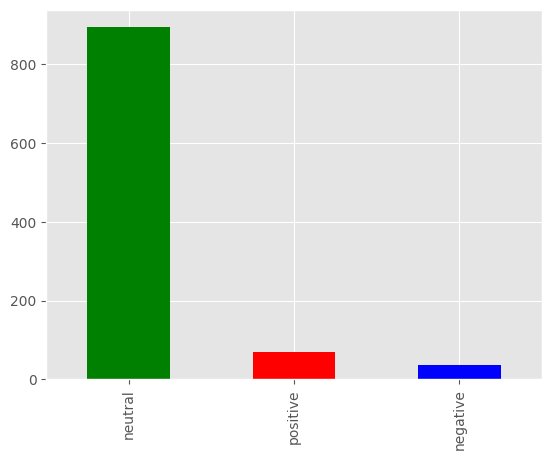

In [42]:
df_concat_tweet_1['sentiment'].value_counts().plot(kind='bar', color=['green', 'red', 'blue'])

In [61]:
df_concat_tweet_1_sent = df_concat_tweet_1[df_concat_tweet_1['sentiment'] == 'neutral']

In [62]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [63]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

## Features for Grouping

In [14]:
df_group = df_concat_tweet.copy()
df_group['date'] = df_group['date'].dt.strftime("%Y-%m-%d")
df_group = df_group.groupby('date').agg({'user_name': 'nunique', 'user_followers': 'sum', 'text' : 'count'}).reset_index()
df_group.columns = ['date', 'unique_users', 'followers', 'tweet_count']